In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [46]:
import json
import tensorflow as tf
import csv
import random
import numpy as np
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

def plot_accuracy_loss(history):

    acc=history.history['accuracy']
    val_acc=history.history['val_accuracy']
    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs=range(len(acc)) # Get number of epochs
    plt.plot(epochs, acc, 'r')
    plt.plot(epochs, val_acc, 'b')
    plt.title('Training and validation accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(["Accuracy", "Validation Accuracy"])

    plt.figure()
    plt.plot(epochs, loss, 'r')
    plt.plot(epochs, val_loss, 'b')
    plt.title('Training and validation loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["Loss", "Validation Loss"])

    plt.figure()


embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size=160000
test_portion=.1

corpus = []


In [47]:
# Note that I cleaned the Stanford dataset to remove LATIN1 encoding to make it easier for Python CSV reader
# You can do that yourself with:
# iconv -f LATIN1 -t UTF8 training.1600000.processed.noemoticon.csv -o training_cleaned.csv
# I then hosted it on my site to make it easier to use in this notebook
"""
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /tmp/training_cleaned.csv
"""
num_sentences = 0
with open("/tmp/training_cleaned.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
      # Your Code here. Create list items where the first item is the text, found in row[5], and the second is the label. Note that the label is a '0' or a '4' in the text. When it's the former, make
      # your label to be 0, otherwise 1. Keep a count of the number of sentences in num_sentences
        list_item=[]
        list_item.append(row[5])
        this_label=row[0]
        if this_label=='0':
            list_item.append(0)
        else:
            list_item.append(1)
        num_sentences = num_sentences + 1
        corpus.append(list_item)

print(num_sentences)
print(len(corpus))
print(corpus[1])

# Expected Output:
# 1600000
# 1600000
# ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [48]:
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])


tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

split = int(test_portion * training_size)

test_sequences = padded[0:split]
training_sequences = padded[split:training_size]
test_labels = labels[0:split]
training_labels = labels[split:training_size]

print(vocab_size)
print(word_index['i'])
# Expected Output
# 138858
# 1

138596
1


In [49]:
# Note this is the 100 dimension version of GloVe from Stanford
# I unzipped and hosted it on my site to make this notebook easier
"""
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
"""
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;


print(len(embeddings_matrix))
# Expected Output
# 138859

138597


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 16, 100)           13859700  
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 100)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                34048     
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 7         
Total params: 13,894,145
Trainable params: 34,445
Non-trainable params: 13,859,700
_________________________________________________________________


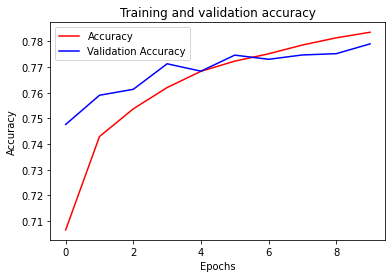

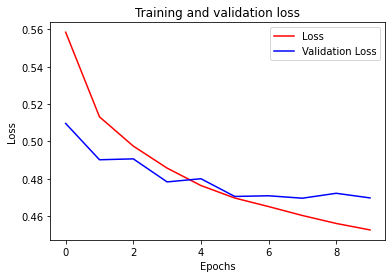

<Figure size 432x288 with 0 Axes>

In [51]:
#FIRST
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    # YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 10
history = model.fit(training_sequences, np.array(training_labels), epochs=num_epochs, validation_data=(test_sequences, np.array(test_labels)), verbose=2)
plot_accuracy_loss(history)


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 16, 100)           13859700  
_________________________________________________________________
bidirectional_5 (Bidirection (None, 16, 128)           84480     
_________________________________________________________________
bidirectional_6 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 13,989,621
Trainable params: 129,921
Non-trainable params: 13,859,700
_________________________________________________________________
Epoch 1/10
4500/4500 - 35s - loss: 0.5324 - accuracy: 0.7284 - val_loss: 0.4978 - val_accuracy: 0.7567

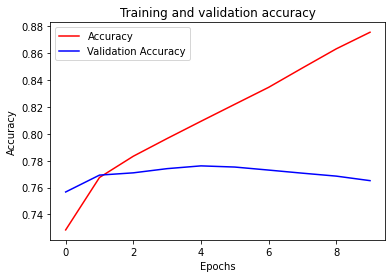

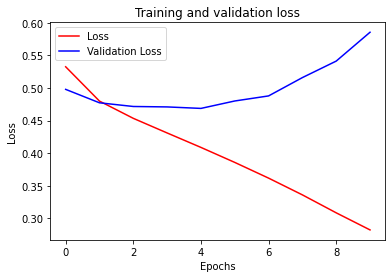

<Figure size 432x288 with 0 Axes>

In [53]:
#SECOND
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()
history = model.fit(training_sequences, np.array(training_labels), epochs=10, validation_data=(test_sequences, np.array(test_labels)), verbose=2)
plot_accuracy_loss(history)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 16, 100)           13859700  
_________________________________________________________________
conv1d (Conv1D)              (None, 12, 128)           64128     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 13,932,149
Trainable params: 72,449
Non-trainable params: 13,859,700
_________________________________________________________________
Epoch 1/10
4500/4500 - 9s - loss: 0.5554 - accuracy: 0.7113 - val_loss: 0.5215 - val_accuracy: 0.7383
E

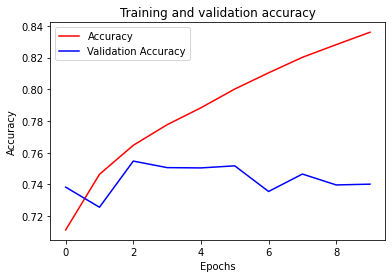

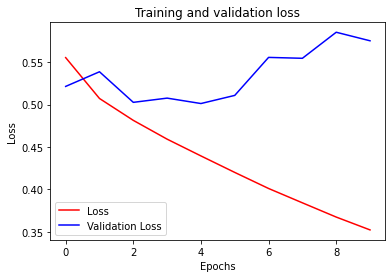

<Figure size 432x288 with 0 Axes>

In [54]:
#THIRD
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()
history = model.fit(training_sequences, np.array(training_labels), epochs=10, validation_data=(test_sequences, np.array(test_labels)), verbose=2)
plot_accuracy_loss(history)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 16, 100)           13859700  
_________________________________________________________________
bidirectional_7 (Bidirection (None, 64)                34048     
_________________________________________________________________
dense_14 (Dense)             (None, 6)                 390       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 7         
Total params: 13,894,145
Trainable params: 34,445
Non-trainable params: 13,859,700
_________________________________________________________________
Epoch 1/10
4500/4500 - 21s - loss: 0.5389 - accuracy: 0.7239 - val_loss: 0.5035 - val_accuracy: 0.7538
Epoch 2/10
4500/4500 - 21s - loss: 0.4911 - accuracy: 0.7587 - val_loss: 0.4859 - val_accuracy: 0.7623
Epoch 3/10
4500/4500 - 20s - 

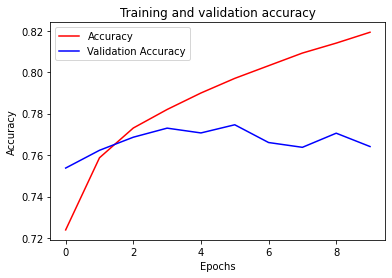

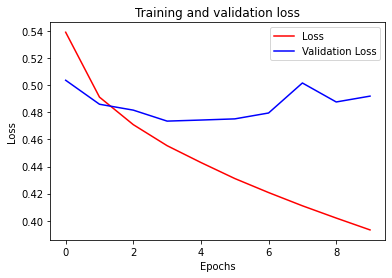

<Figure size 432x288 with 0 Axes>

In [55]:
#FOURTH
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()
history = model.fit(training_sequences, np.array(training_labels), epochs=10, validation_data=(test_sequences, np.array(test_labels)), verbose=2)
plot_accuracy_loss(history)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 16, 100)           13859700  
_________________________________________________________________
bidirectional_8 (Bidirection (None, 64)                34048     
_________________________________________________________________
dense_16 (Dense)             (None, 24)                1560      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 25        
Total params: 13,895,333
Trainable params: 35,633
Non-trainable params: 13,859,700
_________________________________________________________________
Epoch 1/10
4500/4500 - 21s - loss: 0.5365 - accuracy: 0.7250 - val_loss: 0.5151 - val_accuracy: 0.7459
Epoch 2/10
4500/4500 - 20s - loss: 0.4904 - accuracy: 0.7603 - val_loss: 0.4957 - val_accuracy: 0.7554
Epoch 3/10
4500/4500 - 20s - 

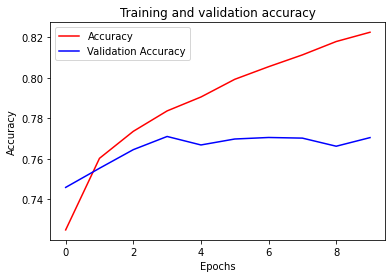

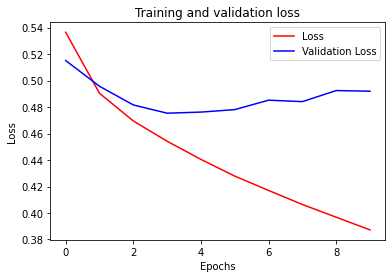

<Figure size 432x288 with 0 Axes>

In [56]:
#FIFTH
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()
history = model.fit(training_sequences, np.array(training_labels), epochs=10, validation_data=(test_sequences, np.array(test_labels)), verbose=2)
plot_accuracy_loss(history)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 16, 100)           13859700  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12, 128)           64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 24)                3096      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 25        
Total params: 13,926,949
Trainable params: 67,249
Non-trainable params: 13,859,700
_________________________________________________________________
Epoch 1/10
4500/4500 - 9s - loss: 0.5478 - accuracy: 0.7154 - val_loss: 0.5212 - val_accuracy: 0.7364
E

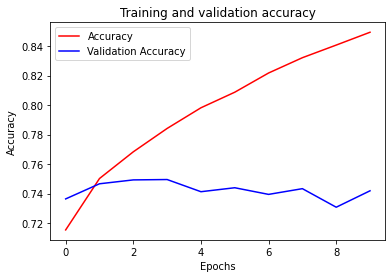

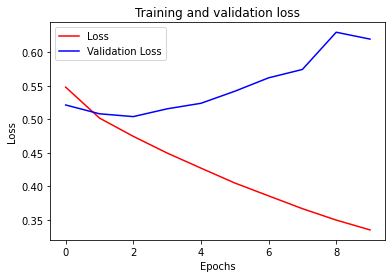

<Figure size 432x288 with 0 Axes>

In [57]:
#SIXTH
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()
history = model.fit(training_sequences, np.array(training_labels), epochs=10, validation_data=(test_sequences, np.array(test_labels)), verbose=2)
plot_accuracy_loss(history)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 16, 100)           13859700  
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 100)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 12, 64)            32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3, 64)             0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 65        
Total params: 13,924,853
Trainable params: 65,153
Non-trainable params: 13,859,700
____________________________________

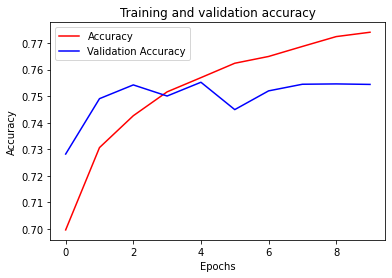

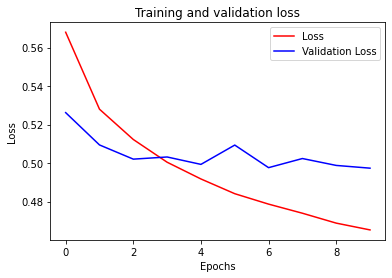

<Figure size 432x288 with 0 Axes>

In [58]:
#SEVENTH
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()
history = model.fit(training_sequences, np.array(training_labels), epochs=10, validation_data=(test_sequences, np.array(test_labels)), verbose=2)
plot_accuracy_loss(history)